In [1]:
#one-hot encode cmc; colors; keywords; produced_mana; 
#average cost per power in set, trade in set, kill in set;
#extract type;
#add trade
#process text (token; replace card name; number of words/char; TF-IDF)
#try to process creature type
#destroy permanent, target sacrifice, life gain, deal damage, loose, draw card (bool or number)

In [38]:
import pandas as pd
import numpy as np
import sqlalchemy as sql
from dotenv import load_dotenv
import os
import re

pd.set_option("display.max_columns", None)

pd.set_option("display.max_rows", 200)

In [3]:
def get_data():
    query = """SELECT d.name, scryfall_id, oracle_text, cmc, colors, keywords, type_line, set_name, `set`, d.rarity, `power`, toughness, produced_mana, loyalty, avg_pick FROM scryfall_cards s
    INNER JOIN draft_data_all2 d ON d.scryfall_id = s.id
    WHERE drat_format = 'PremierDraft';
    """
    load_dotenv()
    user = os.getenv('DB_USERNAME')
    db = os.getenv('DB')
    host = os.getenv('DB_HOST')
    password = os.getenv('DB_PASSWORD')
    connection_string = f"mysql+pymysql://{user}:{password}@{host}/{db}?charset=utf8mb4"
    engine = sql.create_engine(connection_string)
    with engine.connect() as conn:
            df = pd.read_sql_query(query, conn)
    engine.dispose()
    return df


In [68]:
def convert_power_tough(x):
    pattern = re.compile(r"\d+")
    if "*" in x:
        match = re.findall(pattern, x)
        if match == []:
            return int(0)
        else:
            return int(match[0])
    else:
        return int(x)
    
def count_matching_toughness(df, row):
    return (df['toughness'] == row['power']).sum()

def one_hot_expand(dfc, col, prefix, sep=",", clean=True):

    if clean:
        dfc[col] = dfc[col].apply(lambda x: x[1:-1])
        dfc[col] = dfc[col].apply(lambda x: x.replace("'", ""))
        dfc[col] = dfc[col].apply(lambda x: x.replace(" ", ""))
    dfc = dfc[col].str.split(sep, expand=True)
    stacked = dfc.stack()
    one_hot_encoded = pd.get_dummies(stacked, prefix=prefix).groupby(level=0).sum()
    return dfc.join(one_hot_encoded)

def handle_type(x):
    new_type = ""
    if "//" in x:
        new_type = x.split("//")[0]
    else:
        new_type = x
    
    return new_type

def filter_keywords(x):
    keywords_to_keep = ["Ward", "Vigilance", "Unearth", "Transform", "Cycling", "Trample", "Surveil", "Scry", "Reach", "Prowess", "Proliferate", "Ninjutsu", "Mill", "Menace", "Lifelink", "Kicker", "Indestructible", "Hexproof", "Haste", "Flying", "Flash", "Firststrike", "Fight", "Equip", "Enchant", "Doublestrike", "Defender", "Deathtouch", "Convoke", "Affinity" ]
    x = x[1:-1]
    x =  x.replace("'", "")
    x = x.replace(" ", "")
    x = x.split(",")
    new_x = []
    for n in x:
        if n in keywords_to_keep:
            new_x.append(n)
    return str(new_x)

def count_produced_mana(x):
    c = 0
    if type(x) == str:
        for n in x:
            if 'B' in n:
                c += 1
            if 'G' in n:
                c += 1
            if 'U' in n:
                c += 1
            if 'R' in n:
                c += 1
            if 'W' in n:
                c += 1
    return c




In [59]:
def clean_data(df):
    dft = df.copy()
    dft["keywords"] = dft["keywords"].apply(filter_keywords)

    dft["card_type"] = dft["type_line"].apply(lambda x: x.split(" — ")[0])
    dft["Legenday"] = dft["card_type"].apply(lambda x: "Legendary" in x)
    dft["card_type"] = dft["card_type"].apply(lambda x: x.split(" ")[1] if "Legendary" in x else x)

    dft["power_*"] = dft["power"].apply(lambda x: "*" in x)
    dft["toughness_*"] = dft["toughness"].apply(lambda x: "*" in x)
    dft["power"] = dft["power"].apply(convert_power_tough)
    dft["toughness"] = dft["toughness"].apply(convert_power_tough)
    dft["power_toughness"] = dft["power"] + dft["toughness"]

    dft["cmc"] = dft["cmc"].apply(float)
    creature_df = dft[dft["card_type"] == "Creature"]
    grouped_sum = creature_df.groupby("set").agg({"power_toughness": "sum", "cmc": "sum"})
    average_stat_cost = grouped_sum["cmc"] / grouped_sum["power_toughness"]
    dft = dft.merge(average_stat_cost.rename("average_stat_cost"), how="left", on="set")
    dft["card_average_stat_cost"] = dft["cmc"] / dft["power_toughness"]
    dft["card_average_stat_cost"] = dft["card_average_stat_cost"].apply(lambda x: 1 if x > 100 else x)

    creature_df = dft[dft["card_type"] == "Creature"]
    temp = pd.DataFrame()
    for group, sub_df in creature_df.groupby("set"):
        sub_df["can_trade"] = sub_df.apply(lambda x: (sub_df['toughness'] == x['power']).sum(), axis=1)
        temp = pd.concat([temp, sub_df[["scryfall_id", "set", "can_trade"]]])
            
    dft = dft.merge(temp, how="left", on=["scryfall_id", "set"])

    dft["can_trade"] = dft["can_trade"].fillna(0)

    dft = one_hot_expand(dft, "colors", "color")
    dft = dft.rename(columns={"colors_":"uncolored"})

    dft["produced_mana"] = dft.apply(count_produced_mana)
    dft = one_hot_expand(dft, "keywords", "keywords", clean=True)

    dft["card_type"] = dft["card_type"].apply(handle_type)

    dft = one_hot_expand(dft, "card_type", "card_type", " ", clean=False)

    dft = pd.get_dummies(dft, columns=['rarity'])
    
    return dft


In [57]:
def prep_target(df):
    dft = df.copy()
    bin = [0,3,9,13]
    dft["target"] = pd.cut(dft['avg_pick'], bins=bin)
    dft['target'] = dft['target'].cat.codes
    dft["target"].value_counts()
    dft = dft[dft["target"] >= 0]
    drop_col = ["name", "scryfall_id","card_type_" ,"colors", "keywords", "keywords_", "type_line", "set_name", "set", "face","back", "face_type", "face_subtype", "back_type", "back_subtype", "oracle_text", "card_type"]
    dfp = dft.drop(columns=drop_col)
    dfp = dfp.fillna(0)
    return dfp

In [48]:
df = get_data()

In [70]:
df["key"].tail(200)

6924          ['Scry', 'Flying']
6925                   ['Reach']
6926                          []
6927                          []
6928                   ['Haste']
6929                          []
6930                          []
6931                          []
6932                          []
6933                 ['Trample']
6934                          []
6935                  ['Flying']
6936                          []
6937     ['Flying', 'Vigilance']
6938                          []
6939                          []
6940                          []
6941                          []
6942                   ['Equip']
6943                          []
6944                          []
6945                          []
6946        ['Kicker', 'Flying']
6947                   ['Haste']
6948                          []
6949                          []
6950                  ['Flying']
6951                          []
6952                          []
6953                          []
6954      

In [60]:
df2 = clean_data(df)

KeyError: 'keywords'

In [44]:
df2.columns.to_list()

['name',
 'scryfall_id',
 'oracle_text',
 'cmc',
 'colors',
 'keywords',
 'type_line',
 'set_name',
 'set',
 'power',
 'toughness',
 'produced_mana',
 'loyalty',
 'avg_pick',
 'card_type',
 'Legenday',
 'power_*',
 'toughness_*',
 'power_toughness',
 'average_stat_cost',
 'card_average_stat_cost',
 'can_trade',
 'color_',
 'color_B',
 'color_G',
 'color_R',
 'color_U',
 'color_W',
 'keywords_',
 'keywords_Adamant',
 'keywords_Adapt',
 'keywords_Addendum',
 'keywords_Affinity',
 'keywords_Afterlife',
 'keywords_AimfortheCursedAmulet',
 'keywords_Alliance',
 'keywords_Amass',
 'keywords_Ascend',
 'keywords_BattleCry',
 'keywords_Blitz',
 'keywords_Boast',
 'keywords_Casualty',
 'keywords_Changeling',
 'keywords_Channel',
 'keywords_Cleave',
 'keywords_Companion',
 'keywords_Compleated',
 'keywords_Conjure',
 'keywords_Connive',
 'keywords_Constellation',
 'keywords_Convoke',
 'keywords_Corrupted',
 'keywords_Coven',
 'keywords_Crew',
 'keywords_Cycling',
 'keywords_Daybound',
 'keywords_

In [23]:

#supertype
def add_card_supertype(df):
    set_df_kw = df
    single_word = "\w+"
    single_word_hypen = "\w+-\w+"
    regex_1 = f"({single_word}|{single_word_hypen})"
    set_df_kw['tapping_ability'] = np.where(set_df_kw['oracle_text'].str.contains('{T}'),1,0)
    set_df_kw['multiple_choice'] = np.where(set_df_kw['oracle_text'].str.contains('• '),1,0)
    try:
        set_df_kw[['face','back']] = set_df_kw['type_line'].str.split(' // ',expand=True).fillna('None')
    except:
        set_df_kw[['face','back']] = [set_df_kw['type_line'],"None"]

    try:
        set_df_kw[['face_type','face_subtype']] = set_df_kw['face'].str.split(' — ',expand=True).fillna('None')
    except:
        set_df_kw['face_type'] = set_df_kw['face']
        set_df_kw['face_subtype'] = "None"

    try:
        set_df_kw[['back_type','back_subtype']] = set_df_kw['back'].str.split(' — ',expand=True).fillna('None')
    except:
        set_df_kw['back_type'] = set_df_kw['back']
        set_df_kw['back_subtype'] = "None"
    regex_2 = "(land|lands|basic land|basic lands|plains|island|swamp|mountain|forest|plains|islands|swamps|mountains|forests|basic plains|basic island|basic swamp|basic mountain|basic forest|basic plains|basic islands|basic swamps|basic mountains|basic forests)"
    regex_3 = "(a|one|one|two|three|up to one|up to two|up to three|up to ten|up to x|x)"

    regex_4 = "(a|one|up to one|two|up to two|three|up to three|four|up to four|five|up to five|six|up to six|x|up to x)"
    regex_5 = "(all|each|another|another target|x|x target|a|target|any number of|one|up to one|up to one target|two|up to two|up to two target|three|up to three|up to three target|four|up to four|up to four target)"
    regex_6 = "(card|cards|creature|creatures|nonlegendary creature|creature card|creature cards|permanent|permanents|permanent card|permanent cards|land|lands|land card|land cards|instant or sorcery card|equipment card|aura card|aura or equipment card|artifact or enchantment)"
    try:
        set_df_kw['counterspell'] = np.where((set_df_kw['counter_tkn']==1) &

                                                ((set_df_kw['oracle_text'].str.lower().str.contains("counter target")) |
                                                (set_df_kw['oracle_text'].str.lower().str.contains("counter all")) |
                                                (set_df_kw['oracle_text'].str.lower().str.contains("counter it")))
                                                ,1,0)
    except:
        set_df_kw['counterspell'] = 0

    set_df_kw['manarock'] = np.where(
                                    ((set_df_kw['tapping_ability']==1) |
                                        (set_df_kw['oracle_text']).str.lower().str.contains("tap")) &

                                    (set_df_kw['type_line']).str.lower().str.contains("artifact") &

                                    (
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"{t}: add.*?(mana of any color|mana of that color|{(.*?)})",regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"{t}, tap an untapped.*?(mana of any color|mana of that color|{(.*?)})",regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"{t}: choose a color",regex=True)==True)
                                    )
                                    ,1,0)

    set_df_kw['manadork'] = np.where(
                                    (set_df_kw['tapping_ability']==1)&
                                    (set_df_kw['manarock']!=1) &
                                    (set_df_kw['back_type']!="Land") &
                                    (set_df_kw['type_line']).str.lower().str.contains("creature") &

                                    (
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"{t}: add",regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"{t}:.*?add one mana",regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"{t}: add",regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"add (one|two|three|four|five) mana",regex=True)==True)
                                    )
                                    ,1,0)


    set_df_kw['removal'] = np.where(
                                        (
                                        (set_df_kw['oracle_text'].str.lower().str.contains(f"(destroy|exile) target ({regex_1}|({regex_1}, {regex_1})|({regex_1}, {regex_1}, {regex_1})|({regex_1}, {regex_1}, {regex_1}, {regex_1})) (creature|permanent)(?! from (a|your) graveyard| card from (a|your) graveyard)",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(destroy|exile) another target (creature|permanent)",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"destroy any number of target (creature|creatures|permanent|permanents)",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(destroy|exile) target (attacking|blocking|attacking or blocking) creature",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"destroy up to (one|two|three) target (\w+) (creature|permanent|creatures|permanents)",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"exile up to (one|two|three) target (creature|permanent|creatures|permanents)",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"exile up to (one|two|three) target (nonland|nonartifact) (creature|permanent|creatures|permanents)",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"exile up to (one|two|three) target (\w+) (\w+) (creature|permanent|creatures|permanents)",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(destroy|exile) target (\w+) or creature",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(destroy|exile) a (creature|permanent) with the (greatest|highest|lowest) (power|toughness|converted mana cost|mana value)",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(destroy|exile) target (creature|permanent)(?! from a graveyard| card from a graveyard)", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(destroy|exile) up to (\w+) target (attacking or blocking|attacking|blocking) (creature|creatures)", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"target (player|opponent) sacrifices a (creature|permanent)",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"each (player|opponent) sacrifices (a|one|two|three|four) (creature|creatures|permanent|permanents)",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"enchanted (creature|permanent) is a treasure",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"enchanted creature doesn't untap",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(annihilator)")==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"deals damage equal to its power to target creature",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(fights|fight) target creature")==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(those creatures|the chosen creatures) fight each other",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(fights|fight) up to (\w+) target (creature|creatures)", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(fights|fight) another target creature",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"choose target creature you don't control.*?each creature.*?deals damage equal.*?to that creature",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"you may have (cardname|it) fight (that creature|target creature|another target creature)",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"target creature deals damage to itself equal to (its power)",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"target creature gets -[0-9]/-[2-9]", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"target creature gets \+[0-9]/-[2-9]", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"target creature an opponent controls gets \-[0-9]/\-[2-9]", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"enchanted creature (gets|has).*?loses (all|all other) abilities", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"enchanted creature gets \-[0-9]/\-[2-9]", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"enchanted creature gets \-[0-9]/\-[2-9]", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"enchanted creature gets \+[0-9]/\-[2-9]", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(enchanted|target) creature gets \-[0-9][0-9]/\-[0-9][0-9]", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains("target creature gets \-x/\-x")==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains("target creature gets \+x/\-x")==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"target creature an opponent controls gets \-x/\-x", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"enchanted creature gets \-x/\-x", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"enchanted (creature|permanent) can't attack or block",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains("enchanted creature has defender")==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains("enchanted creature can't block.*?its activated abilities can't be activated")==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"enchanted creature.*?loses all abilities",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"enchanted (creature|permanent) can't attack.*?block.*?and its activated abilities can't be activated", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"deals ([2-9|x]) damage.*?(creature|any target|divided as you choose|to each of them)", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"deals ([2-9|x]) damage.*?to each of up to (one|two|three|four) (target|targets)", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"deals damage equal to.*?to (any target|target creature|target attacking creature|target blocking creature|target attacking or blocking creature)", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"target creature deals (.*?) damage to itself", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"deals damage to (any target|target creature|target attacking creature|target blocking creature|target attacking or blocking creature).*?equal to", regex=True)==True)) &

                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(cardname|it) deals [a-zA-Z0-9] damage to that player.",regex=True)==False) &
                                        (set_df_kw['oracle_text'].str.lower().str.contains("(cardname|it) deals [a-zA-Z0-9] damage to target (player|opponent) or planeswalker")==False) &
                                        (set_df_kw['oracle_text'].str.lower().str.contains("(cardname|it) deals [a-zA-Z0-9] damage to that creature's controller")==False) &
                                        (set_df_kw['oracle_text'].str.lower().str.contains("that was dealt damage this turn")==False) &
                                        (set_df_kw['oracle_text'].str.lower().str.contains("^(?!damage|creature)\w* random")==False) &
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"search.*?(creature|artifact|enchantment) card",regex=True)==False) &
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(destroy|exile) target land",regex=True)==False) &
                                        (set_df_kw['oracle_text'].str.lower().str.contains("return it to the battlefield")==False) &
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"return that (card|creature|permanent) to the battlefield",regex=True)==False) &
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"if you control a.*?^(?!liliana)\w* planeswalker",regex=True)==False) &
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"^(?!additional cost|additional cost)\w* exile (target|a|one|two|three|all).*?from (your|a|target opponent's) graveyard",regex=True)==False)
                                        ,1,0)

    set_df_kw['wrath'] = np.where(
                                    (
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"(destroy|exile) (all|all other|each|each other|all attacking) (creature|creatures|(.*?) creatures|permanent|permanents|(.*?) permanents|(nonland|multicolored) permanent|(nonland|multicolored) permanents)",regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"each (creature|other creature) gets -(x|[0-9])/-(x|[2-9])", regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"each creature deals damage to itself equal to", regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"(destroy|exile) all artifacts, creatures, and enchantments", regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"sacrifices (all|that many) (creatures|(.*?) creatures|permanents|(.*?) permanents)", regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"chooses.*?then sacrifices the rest", regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"creatures.*?get -(x|[0-9])/-(x|[2-9])", regex=True)==True) | #Crippling Fear
                                    (set_df_kw['oracle_text'].str.lower().str.contains(f"deals ([3-9]|x|[1-9][0-9]) damage to each (creature|{regex_1} creature)", regex=True)==True)
                                    )
                                    ,1,0)
    set_df_kw['ramp'] = np.where(
                                (set_df_kw['face_type']!="Land") &
                                (set_df_kw['manadork']!=1) &
                                (set_df_kw['manarock']!=1) &
                                (set_df_kw['face_type']!="Snow Land") &
                                (set_df_kw['face_type']!="Artifact Land") &
                                (set_df_kw['type_line'].str.lower().str.contains(r"(\w+) // land", regex=True)==False) &
                                (
                                (set_df_kw['oracle_text'].str.lower().str.contains(r"{t}: add", regex=True)==True) |
                                (set_df_kw['oracle_text'].str.lower().str.contains(r"^(?!{[1-9]}: )\w* add (one|two) mana", regex=True)==True) |
                                (set_df_kw['oracle_text'].str.lower().str.contains(r"{[1]}, {t}: add ({(c|w|u|b|r|g)}{(c|w|u|b|r|g)}|two)", regex=True)==True) |
                                (set_df_kw['oracle_text'].str.lower().str.contains(r"whenever enchanted land is tapped for mana.*?adds", regex=True)==True) |
                                (set_df_kw['oracle_text'].str.lower().str.contains(f"search (your|their) library for {regex_3} {regex_2}.*?put.*?onto the battlefield", regex=True)==True)
                                ) &
                                (
                                (set_df_kw['oracle_text'].str.lower().str.contains(r"{[1-9]}, {t}: add one mana", regex=True)==False) &
                                (set_df_kw['oracle_text'].str.lower().str.contains(r"enchanted land.*?{t}: add {(c|1|w|u|b|r|g)}", regex=True)==False) &
                                (set_df_kw['oracle_text'].str.lower().str.contains(r"destroy target (land|nonbasic land)", regex=True)==False) &
                                (set_df_kw['oracle_text'].str.lower().str.contains(r"spend this mana only to", regex=True)==False)
                                )
                                ,1,0)
    set_df_kw['tutor'] = np.where(
                                (set_df_kw['ramp']!=1) &
                                (set_df_kw['face_type']!="Land") &
                                (set_df_kw['face_type']!="Snow Land") &
                                (set_df_kw['face_type']!="Artifact Land") &
                                (
                                (set_df_kw['oracle_text'].str.lower().str.contains(r"search your (library|library and graveyard) for (a|an|any|any one|one|up to one|two|up to two|three|up to three|four|up to four|a(white|blue|black|red|green|colorless)) (card|cards|permanent|permanents|equipment|aura|aura or equipment|legendary|enchantment|enchantments|artifact|artifacts|creature|(.*?) creature cards|creature cards|creatures|sorcery|sorceries|instant|instants|planeswalker)", regex=True)==True)
                                ) &
                                (
                                (set_df_kw['oracle_text'].str.lower().str.contains(r"put (it|them|those cards|that card) into your graveyard", regex=True)==False) &
                                (set_df_kw['oracle_text'].str.lower().str.contains(r"named", regex=True)==False)
                                )
                                ,1,0)
    set_df_kw['cardraw'] = np.where(
                                    (
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"draw (a|one|two|three|four|five|six|seven|x|(.*?) x) (card|cards)", regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"draw (cards equal to|that many cards)", regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"target player draws (.*?) (card|cards)", regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"(look at|reveal) the.*?put.*?(into|in) your hand", regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"(exile|look at the).*?(card|cards).*?you may (cast|play)", regex=True)==True)
                                    ) &
                                    (
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"whenever you draw a card", regex=True)==False) &
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"if you would draw a card", regex=True)==False) &
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"draw (a|one|two|three|four) (card|cards), then discard (a|one|two|three|four) (card|cards)", regex=True)==False) &
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"discard (a|one|two|three|four) (card|cards), then draw (a|one|two|three|four) (card|cards)", regex=True)==False)
                                    )
                                    ,1,0)

    set_df_kw['burn'] = np.where(
                                (
                                (set_df_kw['oracle_text'].str.lower().str.contains(r"deals ([1-9|x]) damage.*?(any target|player|opponent|to them|to each of them)", regex=True)==True) |
                                (set_df_kw['oracle_text'].str.lower().str.contains(r"deals (x|two|three|four|five) times (damage|x damage).*?(any target|player|opponent|to them|to each of up to)", regex=True)==True) |
                                (set_df_kw['oracle_text'].str.lower().str.contains(r"deals damage equal to.*?to (any target|target player|target opponent|to them|each player|each opponent)", regex=True)==True) |
                                (set_df_kw['oracle_text'].str.lower().str.contains(r"deals damage to (any target|target player|target opponent|to them|each player|each opponent).*?equal to", regex=True)==True) |
                                (set_df_kw['oracle_text'].str.lower().str.contains(r"deals that much damage to (any target|target player|target opponent|each player|each opponent|that source's controller)", regex=True)==True)
                                )
                                ,1,0)

    set_df_kw['discard'] = np.where(
                                    (
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"(that|target|each) (player|opponent) discards (a|one|two|three|that|all|all the) (card|cards)", regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"unless that player.*?discards a card", regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"target (player|opponent) reveals their hand.*?you choose.*?exile (that|it)", regex=True)==True)
                                    )
                                    ,1,0)

    set_df_kw['enters_bf'] = np.where(
                                    (
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"(enter|enters) the battlefield", regex=True)==True)
                                    )
                                    &
                                    (
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"(enter|enters) the battlefield tapped", regex=True)==False) &
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"land (enter|enters) the battlefield", regex=True)==False) &
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"it becomes day", regex=True)==False) &
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"enchant creature", regex=True)==False)
                                    )
                                    ,1,0)

    set_df_kw['die_trigger'] = np.where(
                                        (
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"when (cardname|equipped creature) dies", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"whenever.*?dies", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"whenever.*?you (control|don't control) dies", regex=True)==True)
                                        )
                                        ,1,0)

    set_df_kw['attack_trigger'] = np.where(
                                            (
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"(when|whenever) (cardname|equipped creature|it) attacks", regex=True)==True) |
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"(when|whenever) (cardname|equipped creature|it) and.*?(other|another) (creature|creatures) attack", regex=True)==True) |
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"(battalion|exert|raid)", regex=True)==True) |
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"(when|whenever) (cardname|equipped creature|it) enters the battlefield or attacks", regex=True)==True)
                                            )
                                            ,1,0)

    set_df_kw['pseudo_ramp'] = np.where(
                                        (
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"you may put a (land|basic land).*?onto the battlefield", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(you|each player) may (play|put) an additional land", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"if it's a land card, you may put it onto the battlefield", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"sacrifice.*?add.*?({(.*?)}|to your mana pool|mana of (any|any one) color)", regex=True)==True)
                                        )
                                        ,1,0)
    set_df_kw['creature_tokens'] = np.where(
                                            (
                                            (set_df_kw['oracle_text'].str.lower().str.contains(f"(create|put) {regex_4}.*?creature (token|tokens)", regex=True)==True) |
                                            (set_df_kw['oracle_text'].str.lower().str.contains(f"(living weapon|amass|fabricate|afterlife|populate)", regex=True)==True) |
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"(creature tokens|creature tokens with.*?) are created instead", regex=True)==True)
                                            )
                                            ,1,0)
    set_df_kw['plus1_counters'] = np.where(
                                            (
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"\+1/\+1 (counter|counters)", regex=True)==True) |
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"(evolve|mentor|adapt|bolster|bloodthirst|devour|monstrosity|reinforce|training)", regex=True)==True)
                                            )
                                            ,1,0)
    set_df_kw['bounce_spell'] = np.where(
                                        (
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"return.*?to (it's|its|their) (owner's|owners') (hand|hands)", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"owner.*?puts it.*?(top|bottom).*?library", regex=True)==True)
                                        )
                                        &
                                        (
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"^(?!islands)\w* you control", regex=True)==False) &
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(when|whenever).*?dies.*?return.*?to its owner's hand", regex=True)==False) &
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"return (cardname|the exiled card) to its owner's hand", regex=True)==False) &
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"whenever cardname.*?return it to its owner's hand", regex=True)==False)
                                        )
                                        ,1,0)
    set_df_kw['costx_less'] = np.where(
                                        (
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(cost|costs) (.*?) less to cast", regex=True)==True)
                                        )
                                        ,1,0)
    set_df_kw['whenever_opp'] = np.where(
                                        (
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"whenever (an opponent|a player)", regex=True)==True)
                                        )
                                        ,1,0)
    set_df_kw['looting_similar'] = np.where(
                                            (
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"draw (a|one|two|three|four) (card|cards), then discard (a|one|two|three|four) (card|cards)",regex=True)==True) |
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"discard (a|one|two|three|four) (card|cards)(,|:) (draw|then draw) (a|one|two|three|four) (card|cards)",regex=True)==True) |
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"create (.*?) (blood|clue) token",regex=True)==True) |
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"cycling",regex=True)==True)
                                            )
                                            ,1,0)

    set_df_kw['disenchant'] = np.where(
                                        (
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(destroy|exile) (target|each|every) (artifact or enchantment|artifact|enchantment)",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"destroy (x) target (artifacts or enchantments|artifacts|enchantments)",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"destroy all (artifacts or enchantments|artifacts|enchantments)",regex=True)==True)
                                        )
                                        ,1,0)
    set_df_kw['life_lose'] = np.where(
                                        (
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(each opponent|each player|target opponent|target player).*?loses (.*?) life",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(afflict|extort)",regex=True)==True)
                                        )
                                        ,1,0)
    set_df_kw['blinker'] = np.where(
                                    (
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"exile (up to (one|two) target|up to (one|two) other target|target|another target|any number of target) (creature|creatures|(.*?) creature|permanent|permanents|(.*?) permanent|(.*?) or creature).*?return.*?to the battlefield",regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"exile (target|another target) (permanent|creature).*?return (that card|that permanent|it) to the battlefield under its owner's control",regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"exile (two|three|four|five|all|each).*?you (control|own).*?then return (them|those).*?to the battlefield",regex=True)==True)
                                    )
                                    ,1,0)
    set_df_kw['agressive'] = np.where(
                                        (set_df_kw['type_line'].str.lower().str.contains("creature")) &
                                        (
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(haste|riot|dash)",regex=True)==True)
                                        )
                                        ,1,0)
    set_df_kw['create_copy'] = np.where(
                                        (
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"create a copy of",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(that's|as) a copy of",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"copy (target|it|them|that spell|that ability)",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"you may copy",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"(storm)",regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"becomes a copy",regex=True)==True)
                                        )
                                        ,1,0)

    set_df_kw['difficult_block'] = np.where(
                                            (set_df_kw['type_line'].str.lower().str.contains("creature")) &
                                            (
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"cardname can't be blocked by",regex=True)==True) |
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"(menace|first strike|flying|deathtouch|double strike|fear|intimidate)",regex=True)==True)
                                            )
                                            ,1,0)
    set_df_kw['gain_control'] = np.where(
                                        (
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"gain control of",regex=True)==True)
                                        )
                                        ,1,0)
    set_df_kw['whenever_cast'] = np.where(
                                            (
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"(whenever you cast|prowess)",regex=True)==True)
                                            )
                                            &
                                            (
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"you may transform", regex=True)==False)
                                            )
                                            ,1,0)
    set_df_kw['cost_reduction'] = np.where(
                                            (
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"(delve|convoke|affinity|foretell|madness|miracle|spectacle)", regex=True)==True) |
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"evoke", regex=True)==True) |
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"you may pay.*?to cast this spell", regex=True)==True) |
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"you may pay (.*?) rather than pay", regex=True)==True)
                                            )
                                            ,1,0)
    set_df_kw['protection'] = np.where(
                                        (
                                        (set_df_kw['oracle_text'].str.lower().str.contains(f"(hexproof|ward|indestructible|shroud)", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(f"can't (be|become) (the|target)", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(f"protection from", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(f"becomes the target of a spell", regex=True)==True)
                                        )
                                        &
                                        (
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"becomes the target of.*?sacrifice (it|cardname)", regex=True)==False) &
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"becomes the target of.*?shuffle.*?into its owner's library", regex=True)==False) &
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"becomes.*?with hexproof.*?until end of turn", regex=True)==False)
                                        )
                                        ,1,0)
    set_df_kw['life_gain'] = np.where(
                                    (
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"gain (.*?) life", regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"gains (.*?) x life", regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"gain life equal", regex=True)==True) |
                                    (set_df_kw['oracle_text'].str.lower().str.contains(r"(lifelink|extort)", regex=True)==True)
                                    )
                                    ,1,0)
    set_df_kw['combat_trigger'] = np.where(
                                            (
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"beginning of (combat|each combat)", regex=True)==True) |
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"deals combat damage", regex=True)==True)
                                            )
                                            ,1,0)

    set_df_kw['endstep_trigger'] = np.where(
                                            (
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"beginning of (your|enchanted player's|each) end step", regex=True)==True)
                                            )
                                            &
                                            (
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"sacrifice.*? at the beginning of your end step", regex=True)==False)
                                            )
                                            ,1,0)
    set_df_kw['upkeep_trigger'] = np.where(
                                            (
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"beginning of (your|enchanted player's|each|each player's) upkeep", regex=True)==True)
                                            )
                                            &
                                            (
                                            (set_df_kw['oracle_text'].str.lower().str.contains(r"beginning of your upkeep, sacrifice cardname", regex=True)==False)
                                            )
                                            ,1,0)
    set_df_kw['lord'] = np.where(
                                (
                                (set_df_kw['type_line'].str.lower().str.contains("creature")) |
                                (set_df_kw['type_line'].str.lower().str.contains("artifact")) |
                                (set_df_kw['type_line'].str.lower().str.contains("enchantment"))
                                ) &
                                (
                                (set_df_kw['oracle_text'].str.lower().str.contains(r"get \+[1-9]/\+[0-9]", regex=True)==True) |
                                (set_df_kw['oracle_text'].str.lower().str.contains(r"(battle cry)", regex=True)==True) |
                                (set_df_kw['oracle_text'].str.lower().str.contains(r"each (creature|other creature).*?gets \+[1-9]/\+[0-9]", regex=True)==True)
                                )
                                &
                                (
                                (set_df_kw['oracle_text'].str.lower().str.contains(r"until end of turn", regex=True)==False)
                                )
                                ,1,0)
    set_df_kw['castfrom_gy'] = np.where(
                                        (
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"you may cast cardname from your graveyard", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"flashback {", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"jump-start", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"escape—{", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"disturb {", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"unearth {", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"retrace", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(r"embalm", regex=True)==True)
                                        )
                                        ,1,0)
    set_df_kw['reanimation'] = np.where(
                                        (
                                        (set_df_kw['oracle_text'].str.lower().str.contains(fr"(return|put) {regex_5} {regex_6}.*?from (your|a) graveyard (to|onto) the battlefield", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(fr"return cardname from your graveyard to the battlefield", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(fr"choose.*?graveyard.*?return.*?to the battlefield", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(fr"return.*?up to.*?from your graveyard to the battlefield", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(fr"enchant creature card in (a|your) graveyard.*?return enchanted creature card to the battlefield under your control", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(fr"(return|returns|put) (all|any number of) (creature|permanent|enchantment|artifact|legendary permanent|legendary creature|nonlegendary creature|nonlegendary permanents|(.*?), (.*?) and (.*?)) cards.*?from (their|your|all) (graveyard|graveyards) (to|onto) the battlefield", regex=True)==True) |
                                        (set_df_kw['oracle_text'].str.lower().str.contains(fr"(return|put) (target|another target).*?card from your graveyard to the battlefield", regex=True)==True)
                                        )
                                        ,1,0)
    set_df_kw['returnfrom_gy'] = np.where(
                                            (
                                            (set_df_kw['oracle_text'].str.lower().str.contains(fr"return {regex_5} {regex_6}.*?from your graveyard to your hand", regex=True)==True) |
                                            (set_df_kw['oracle_text'].str.lower().str.contains(fr"return cardname from your graveyard to your hand", regex=True)==True) |
                                            (set_df_kw['oracle_text'].str.lower().str.contains(fr"choose.*?graveyard.*?return.*?to your hand", regex=True)==True) |
                                            (set_df_kw['oracle_text'].str.lower().str.contains(fr"return.*?up to.*?from your graveyard to your hand", regex=True)==True) |
                                            (set_df_kw['oracle_text'].str.lower().str.contains(fr"return (target|another target).*?card from your graveyard to your hand", regex=True)==True)
                                            )
                                            ,1,0)
    return set_df_kw

In [24]:
df2 = add_card_supertype(df2)

/tmp/ipykernel_65063/3025993203.py:48: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  (set_df_kw['oracle_text'].str.lower().str.contains(r"{t}: add.*?(mana of any color|mana of that color|{(.*?)})",regex=True)==True) |
/tmp/ipykernel_65063/3025993203.py:49: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  (set_df_kw['oracle_text'].str.lower().str.contains(r"{t}, tap an untapped.*?(mana of any color|mana of that color|{(.*?)})",regex=True)==True) |
/tmp/ipykernel_65063/3025993203.py:64: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  (set_df_kw['oracle_text'].str.lower().str.contains(r"add (one|two|three|four|five) mana",regex=True)==True)
/tmp/ipykernel_65063/3025993203.py:71: UserWarning: This pattern is interpreted as a regular

In [25]:
df2 = prep_target(df2)

In [49]:
df2.head()

,cmc,power,toughness,loyalty,avg_pick,Legenday,power_*,toughness_*,power_toughness,average_stat_cost,card_average_stat_cost,can_trade,color_,color_B,color_G,color_R,color_U,color_W,produced_mana_B,produced_mana_C,produced_mana_G,produced_mana_R,produced_mana_U,produced_mana_W,"keywords_""CalimsBreath""",keywords_Adamant,keywords_Adapt,keywords_Addendum,keywords_Affinity,keywords_Afterlife,keywords_AimfortheCursedAmulet,keywords_AimfortheWyvern,keywords_Alliance,keywords_Amass,keywords_Ascend,keywords_BattleCry,keywords_Blitz,keywords_Boast,keywords_Casualty,keywords_Changeling,keywords_Channel,keywords_Cleave,keywords_Companion,keywords_Compleated,keywords_Conjure,keywords_Connive,keywords_Constellation,keywords_Convoke,keywords_Corrupted,keywords_Coven,keywords_Crew,keywords_Cycling,keywords_Daybound,keywords_Deathtouch,keywords_Defender,keywords_Disturb,keywords_Domain,keywords_Doublestrike,keywords_Enchant,keywords_Enlist,keywords_Enrage,keywords_Equip,keywords_Escape,keywords_Exploit,keywords_Explore,keywords_Fight,keywords_FireaWarningShot,keywords_Firststrike,keywords_Flash,keywords_Flashback,keywords_Flying,keywords_ForMirrodin!,keywords_Forestcycling,keywords_Foretell,keywords_GiftofTiamat,keywords_Haste,keywords_Hexproof,keywords_Hexprooffrom,keywords_Hideaway,keywords_HomunculusServant,keywords_Indestructible,keywords_Intensity,keywords_Investigate,keywords_Islandcycling,keywords_Jump-start,keywords_Kicker,keywords_Landcycling,keywords_Landfall,keywords_Learn,keywords_Lifelink,keywords_Magecraft,keywords_Meld,keywords_Menace,keywords_Mentor,keywords_Mill,keywords_MoltingExoskeleton,keywords_Mountaincycling,keywords_Mutate,keywords_NaturalRecovery,keywords_Nightbound,keywords_Ninjutsu,keywords_Packtactics,keywords_Plainscycling,keywords_Proliferate,keywords_Protection,keywords_Prototype,keywords_Prowess,keywords_PsionicAdept,keywords_RageBeyondDeath,keywords_Raid,keywords_Reach,keywords_ReadAhead,keywords_Reconfigure,keywords_Riot,keywords_Scry,keywords_Seek,keywords_Spectacle,keywords_Surveil,keywords_Swampcycling,keywords_Toxic,keywords_Training,keywords_Trample,keywords_Transform,keywords_Typecycling,keywords_Undergrowth,keywords_Unearth,keywords_Ventureintothedungeon,keywords_Vigilance,keywords_Ward,keywords_WildShape,card_type_,card_type_Artifact,card_type_Basic,card_type_Battle,card_type_Creature,card_type_Enchantment,card_type_Instant,card_type_Land,card_type_Planeswalker,card_type_Snow,card_type_Sorcery,rarity_basic,rarity_common,rarity_mythic,rarity_rare,rarity_uncommon,tapping_ability,multiple_choice,counterspell,manarock,manadork,removal,wrath,ramp,tutor,cardraw,burn,discard,enters_bf,die_trigger,attack_trigger,pseudo_ramp,creature_tokens,plus1_counters,bounce_spell,costx_less,whenever_opp,looting_similar,disenchant,life_lose,blinker,agressive,create_copy,difficult_block,gain_control,whenever_cast,cost_reduction,protection,life_gain,combat_trigger,endstep_trigger,upkeep_trigger,lord,castfrom_gy,reanimation,returnfrom_gy,target
0,3.0,2,3,0,9.530148,False,False,False,5,0.641143,0.600000,37.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2
1,3.0,3,1,0,1.724779,True,False,False,4,0.641143,0.750000,37.0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5.0,4,4,0,4.181749,False,False,False,8,0.566906,0.625000,25.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


X, y = df2.drop(columns=["target", "avg_pick"]), df2["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_classifier = RandomForestClassifier(n_estimators=5000, random_state=42, n_jobs=-1)

rf_classifier.fit(X_train, y_train)


y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

cr = classification_report(y_test, y_pred)
print('Classification Report:')
print(cr)


Accuracy: 0.79
Confusion Matrix:
[[200  31   1]
 [ 42 532  89]
 [  0 103 248]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       232
           1       0.80      0.80      0.80       663
           2       0.73      0.71      0.72       351

    accuracy                           0.79      1246
   macro avg       0.79      0.79      0.79      1246
weighted avg       0.79      0.79      0.79      1246



In [30]:
mask = y_pred != y_test

In [31]:
X_test[mask]

,cmc,power,toughness,produced_mana,loyalty,Legenday,power_*,toughness_*,power_toughness,average_stat_cost,card_average_stat_cost,can_trade,color_,color_B,color_G,color_R,color_U,color_W,keywords_acktactic,keywords_agecraf,keywords_ai,keywords_andcyclin,keywords_andfal,keywords_ar,keywords_ast,keywords_asualt,keywords_attleCr,keywords_aturalRecover,keywords_ayboun,keywords_cr,keywords_daman,keywords_dap,keywords_ddendu,keywords_eac,keywords_eadAhea,keywords_ear,keywords_eathtouc,keywords_econfigur,keywords_ee,keywords_efende,keywords_el,keywords_enac,keywords_ento,keywords_entureintothedungeo,keywords_exproo,keywords_exprooffro,keywords_ffinit,keywords_fterlif,keywords_hangelin,keywords_hanne,keywords_icke,keywords_ideawa,keywords_ifelin,keywords_iftofTiama,keywords_igh,keywords_igilanc,keywords_il,keywords_ildShap,keywords_imfortheCursedAmule,keywords_injuts,keywords_io,keywords_irststrik,keywords_lainscyclin,keywords_las,keywords_lashbac,keywords_leav,keywords_lit,keywords_llianc,keywords_lyin,keywords_mas,keywords_nchan,keywords_ndergrowt,keywords_ndestructibl,keywords_neart,keywords_nlis,keywords_nrag,keywords_ntensit,keywords_nvestigat,keywords_oas,keywords_oltingExoskeleto,keywords_omai,keywords_ompanio,keywords_ompleate,keywords_omunculusServan,keywords_onjur,keywords_onniv,keywords_onstellatio,keywords_onvok,keywords_orMirrodin,keywords_oretel,keywords_orrupte,keywords_oublestrik,keywords_ountaincyclin,keywords_ove,keywords_oxi,keywords_pectacl,keywords_qui,keywords_rainin,keywords_rampl,keywords_ransfor,keywords_re,keywords_roliferat,keywords_rotectio,keywords_rototyp,keywords_rowes,keywords_scap,keywords_scen,keywords_sionicAdep,keywords_slandcyclin,keywords_ump-star,keywords_urvei,keywords_utat,keywords_xploi,keywords_xplor,keywords_yclin,card_type_Artifact,card_type_Basic,card_type_Battle,card_type_Creature,card_type_Enchantment,card_type_Instant,card_type_Land,card_type_Planeswalker,card_type_Snow,card_type_Sorcery,rarity_basic,rarity_common,rarity_mythic,rarity_rare,rarity_uncommon,tapping_ability,multiple_choice,counterspell,manarock,manadork,removal,wrath,ramp,tutor,cardraw,burn,discard,enters_bf,die_trigger,attack_trigger,pseudo_ramp,creature_tokens,plus1_counters,bounce_spell,costx_less,whenever_opp,looting_similar,disenchant,life_lose,blinker,agressive,create_copy,difficult_block,gain_control,whenever_cast,cost_reduction,protection,life_gain,combat_trigger,endstep_trigger,upkeep_trigger,lord,castfrom_gy,reanimation,returnfrom_gy
2519,2.0,0,0,0.0,0,False,False,False,0,0.597378,1.000000,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5203,2.0,0,0,0.0,0,False,False,False,0,0.624514,1.000000,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
349,5.0,5,4,0.0,0,True,False,False,9,0.719298,0.555556,8.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
689,7.0,0,0,0.0,0,False,False,False,0,0.578534,1.000000,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4731

In [39]:
df2.iloc[5203]

cmc                                  4.0
power                                  3
toughness                              5
produced_mana                        0.0
loyalty                                0
avg_pick                            1.67
Legenday                            True
power_*                            False
toughness_*                        False
power_toughness                        8
average_stat_cost               0.565217
card_average_stat_cost               0.5
can_trade                           34.0
color_                                 0
color_B                                1
color_G                                0
color_R                                1
color_U                                0
color_W                                1
keywords_acktactic                     0
keywords_agecraf                       0
keywords_ai                            0
keywords_andcyclin                     0
keywords_andfal                        0
keywords_ar     

In [34]:
y_pred

array([0, 1, 0, ..., 2, 1, 2], dtype=int8)

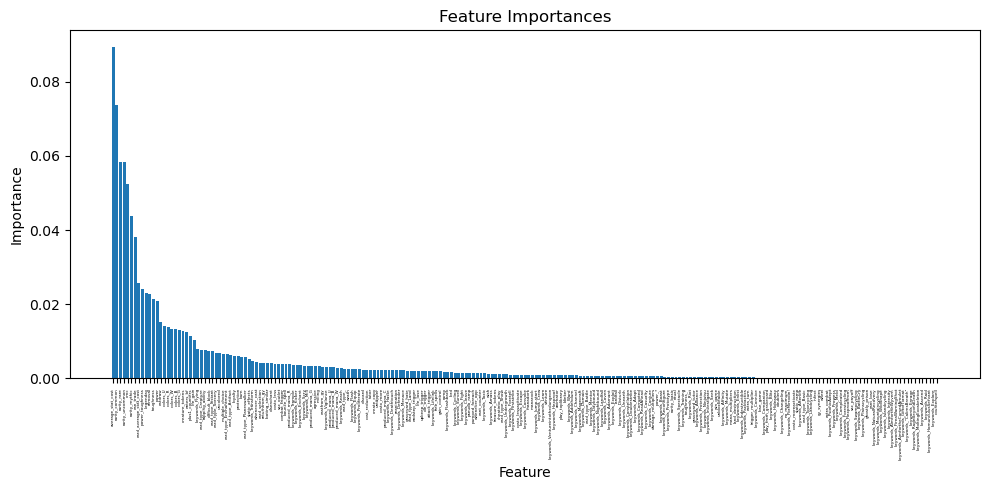

In [183]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming rf_classifier is your trained RandomForestClassifier instance
# Extract feature importances
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
feature_names = [X.columns[i] for i in indices]

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), feature_names, rotation=90, fontsize=3)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')

# Show the plot
plt.tight_layout()
plt.show()


In [185]:
dfi = pd.DataFrame({'Feature': feature_names, 'Importance': importances[indices]})

In [195]:
to_drop = dfi["Feature"].tail(200).to_list()

In [196]:
dfp = dfp.drop(columns=to_drop)

In [197]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


X, y = dfp.drop(columns=["target", "avg_pick"]), dfp["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_classifier = RandomForestClassifier(n_estimators=5000, random_state=42, n_jobs=-1)

rf_classifier.fit(X_train, y_train)


y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

cr = classification_report(y_test, y_pred)
print('Classification Report:')
print(cr)


Accuracy: 0.76
Confusion Matrix:
[[201  29   2]
 [ 50 508 105]
 [  3 114 234]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       232
           1       0.78      0.77      0.77       663
           2       0.69      0.67      0.68       351

    accuracy                           0.76      1246
   macro avg       0.75      0.77      0.76      1246
weighted avg       0.76      0.76      0.76      1246



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming rf_classifier is your trained RandomForestClassifier instance
# Extract feature importances
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
feature_names = [X.columns[i] for i in indices]

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), feature_names, rotation=90, fontsize=10)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')

# Show the plot
plt.tight_layout()
plt.show()
